**  KAGGLE AUTHENTICATION THROUGH UPLOADING API FILE**

In [0]:
import zipfile
from google.colab import auth
auth.authenticate_user()

In [0]:
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw------- 1 root root 63 May  8 07:08 kaggle.json
{"username":"ferdi33","key":"98cb2f31922e43ead612a3740a2b75f7"}

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.1MB/s 
     |████████████████████████████████| 5.3MB 8.3MB/s 
     |████████████████████████████████| 51kB 21.0MB/s 
     |████████████████████████████████| 102kB 31.0MB/s 


**DOWNLOADING AND UNZIPPING FILES**

In [0]:
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 43.7MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 46.8MB/s]
100% 1.30G/1.30G [00:12<00:00, 108MB/s]
100% 1.30G/1.30G [00:12<00:00, 109MB/s]
100% 4.98G/4.98G [00:43<00:00, 150MB/s]
100% 4.98G/4.98G [00:43<00:00, 122MB/s]


In [0]:

zipf = zipfile.ZipFile('../content/train.zip')
zipf.extractall('../content/train')

In [0]:
zipf = zipfile.ZipFile('../content/test.zip')
zipf.extractall('../content/test/test')

In [0]:
! rm -r ../content/train_labels.csv
zipf = zipfile.ZipFile('../content/train_labels.csv.zip')
zipf.extractall()

In [1]:
# Añadir la extensión .tiff en el csv con los labels, para que el flow_from_dataframe pueda leer las imagenes.
import pandas as pd
df = pd.read_csv('../content/train_labels.csv')

df['label'] = df['label'].astype(str)
df['id'] = df['id'].apply(lambda x: x+'.tif')

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [0]:
# Split en validation/train
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

In [3]:
import keras
from keras_preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [10]:
datagen=ImageDataGenerator(rescale=1./255
                          #rotation_range=45,
                          #horizontal_flip=True,
                          #vertical_flip=True,
                          )

train_generator=datagen.flow_from_dataframe(dataframe=train_df, 
                                            directory="../content/train", 
                                            x_col="id", y_col="label", 
                                            class_mode="categorical", 
                                            target_size=(32,32), 
                                            batch_size=64)

validation_generator=datagen.flow_from_dataframe(dataframe=valid_df, 
                                                 directory="../content/train", 
                                                 x_col="id", y_col="label", 
                                                 class_mode="categorical", 
                                                 target_size=(32,32), 
                                                 batch_size=64)

Found 176020 images belonging to 2 classes.
Found 44005 images belonging to 2 classes.


**NN MODEL**

In [11]:
from keras import models
from keras import layers
from keras.layers.convolutional import SeparableConv2D

model = models.Sequential()
model.add(layers.SeparableConv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_2 (Separabl (None, 30, 30, 32)        155       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
__________

In [0]:
from keras import callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.025, patience=10, verbose=1, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.025, patience=5, min_lr=0.001, factor=0.5, verbose=1)
model_checker=callbacks.ModelCheckpoint(filepath='models/' + 'first_model', monitor='val_accuracy', save_best_only=True, save_weights_only=True, verbose=1)
tensorboard = callbacks.TensorBoard(log_dir='logs/first_model')

In [13]:
n_epochs = 10
batch_size=64

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = n_epochs)

Epoch 1/10
2750/2750 [==============================] - 1132s 412ms/step - loss: 0.4326 - acc: 0.8042 - val_loss: 0.5641 - val_acc: 0.7215
Epoch 2/10
2750/2750 [==============================] - 1106s 402ms/step - loss: 0.3914 - acc: 0.8268 - val_loss: 0.5600 - val_acc: 0.7504
Epoch 3/10
2750/2750 [==============================] - 1109s 403ms/step - loss: 0.3691 - acc: 0.8391 - val_loss: 0.3947 - val_acc: 0.8230
Epoch 4/10
2750/2750 [==============================] - 1127s 410ms/step - loss: 0.3574 - acc: 0.8442 - val_loss: 0.4510 - val_acc: 0.8287
Epoch 5/10
2750/2750 [==============================] - 1118s 407ms/step - loss: 0.3465 - acc: 0.8504 - val_loss: 0.3927 - val_acc: 0.8335
Epoch 6/10
2750/2750 [==============================] - 1130s 411ms/step - loss: 0.3389 - acc: 0.8538 - val_loss: 0.6871 - val_acc: 0.7952
Epoch 7/10
2750/2750 [==============================] - 1116s 406ms/step - loss: 0.3331 - acc: 0.8569 - val_loss: 0.4720 - val_acc: 0.8150
Epoch 8/10
2750/2750 [=====

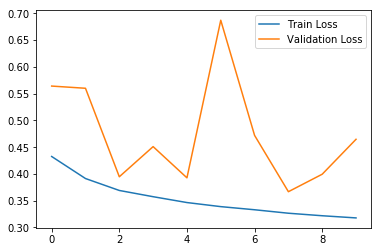

In [14]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

**GENERATE THE PREDICTIONS**





In [17]:
import os
test_dir = '../content/test/test'
test_datagen = ImageDataGenerator(rescale=1./255)


print(os.getcwd()+os.path.sep+test_dir)
test_generator = test_datagen.flow_from_directory(
        '../content/test',
        target_size=(32, 32),
        color_mode="rgb",
        batch_size=2,
        shuffle=False)
filenames = test_generator.filenames
nb_samples = len(filenames)

/content/../content/test/test
Found 57458 images belonging to 1 classes.


In [18]:
predictions = model.predict_generator(test_generator,steps = nb_samples//2, verbose=1)

28729/28729 [==============================] - 2577s 90ms/step


In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [20]:
predictions[:10]

array([[0.0097725 , 0.99022746],
       [0.06892144, 0.93107855],
       [0.21245712, 0.7875429 ],
       [0.96496916, 0.03503085],
       [0.52899516, 0.4710049 ],
       [0.38494495, 0.6150551 ],
       [0.05284428, 0.9471558 ],
       [0.8379045 , 0.16209553],
       [0.553332  , 0.44666806],
       [0.15455958, 0.84544045]], dtype=float32)

In [0]:
import numpy as np
predicted_class_indices=np.argmax(predictions,axis=1)

In [22]:
predicted_class_indices[:10]

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [0]:
predictions = [labels[k] for k in predicted_class_indices]

**UPLOAD THE PREDICTIONS TO KAGGLE**

In [24]:
filenames=test_generator.filenames
print(filenames[:10])

['test/00006537328c33e284c973d7b39d340809f7271b.tif', 'test/0000ec92553fda4ce39889f9226ace43cae3364e.tif', 'test/00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif', 'test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif', 'test/000270442cc15af719583a8172c87cd2bd9c7746.tif', 'test/000309e669fa3b18fb0ed6a253a2850cce751a95.tif', 'test/000360e0d8358db520b5c7564ac70c5706a0beb0.tif', 'test/00040095a4a671280aeb66cb0c9231e6216633b5.tif', 'test/000698b7df308d75ec9559ef473a588c513a68aa.tif', 'test/0006e1af5670323331d09880924381d67d79eda0.tif']


In [25]:
# Remove .tiff extension and /test at the beginning
filenames = [x[:-4] for x in filenames]
filenames = [x[5:] for x in filenames]
print(filenames[:5])

['00006537328c33e284c973d7b39d340809f7271b', '0000ec92553fda4ce39889f9226ace43cae3364e', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2', '000253dfaa0be9d0d100283b22284ab2f6b643f6', '000270442cc15af719583a8172c87cd2bd9c7746']


In [0]:
results=pd.DataFrame({"id":filenames,
                      "label":predictions})
results.to_csv("results.csv",index=False)

In [27]:
import kaggle
!kaggle competitions submit histopathologic-cancer-detection -f "../content/results.csv" -m "Back to simple"

100% 2.36M/2.36M [00:04<00:00, 558kB/s]
Successfully submitted to Histopathologic Cancer Detection